In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#import functions as ff
#import newfunctions as nff
#import functionsDt1 as dff

from darts import TimeSeries as ts 
from darts import concatenate

from sklearn.metrics import mean_absolute_error,r2_score

from scipy.stats import friedmanchisquare

import scikit_posthocs as sp

import pickle
import warnings
warnings.filterwarnings("ignore")

#working from py file results in error due to tsfresh extract_features so we make pipeline in notebook
#to reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2

In [64]:
import os
fileList = os.listdir();
fileList = [i for i in fileList if ('.pickle' in i)&('Cost' in i)&('ensemble' not in i)]; fileList

['maeCost_24x1_const020x30_len780_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_constA20x30_len513_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_constM20x30_len640_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_Sel_rollingTrue_ValFalse_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingFalse_ValFalse_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingFalse_ValTrue_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingTrue_ValFalse_len600_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_TSFresh_rollingTrue_ValTrue_len600_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_uku_rollingTrue_ValFalse_len600_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_GB20x30_uku_rollingTrue_ValTrue_len599_par0.2_bExtra0.07_sExtra-0.01_cyc1.pickle',
 'maeCost_24x1_oracle20x30_len780_par0.2_bExtra0.07_sExtra

In [65]:
pickle.load(open(fileList[0], "rb")).keys()

dict_keys(['costOpt', 'mae', 'costDef', 'costNoBat', 'params', 'idx', 'trainTestInfo', 'eics'])

In [66]:
a ={}
for filename in fileList:
    d=pickle.load(open(filename, "rb"))
    cols = {i:d[i] for i in {i for i in d if 'params' not in i}}
    algo1 = filename.split('maeCost_24x1_')[1].split('_len')[0]
    algoRegr = algo1.split('20x30')[0]
    if len(algoRegr) == 2: 
        algo1 = algoRegr.lower()
        algo1 = algo1 + ' 1m'
    
    algo2 = filename.split('20x30_')[1].split('len')[0]
    if len(algo2)==0: algo = algoRegr
    else: 
        algo2 = algo2.replace('Sel','autofeat')
        algo2 = algo2.replace('TSFresh','tsfresh')
        algo2 = algo2.replace('Val','bestVal')
        algo2 = algo2.replace('True','T')
        algo2 = algo2.replace('False','F')
        algo2 = algo2.replace('bestValT','') #default dont show anything
        algo=algo1+'_'+algo2
    algo = algo.replace('_',' ').strip()
    a[algo] = pd.DataFrame(cols).rename(columns={'costOpt':'cost'})    

In [67]:
cols = ['cost','mae','eics','idx']

results = pd.DataFrame()
for i,df in enumerate(a):
    dd = a[df][cols].set_index(['eics','idx']).rename(mapper = lambda x: x+': '+df, axis='columns')
    if i == 0: results = dd
    else: results = pd.concat([dd,results],axis=1,join='inner')
#results = results.dropna(axis=0)

In [68]:
results.shape

(313, 22)

In [69]:
results.isna().sum().sum()

0

In [70]:
results_mean = results.mean(axis=0).to_frame().T.assign(name='mean').set_index('name').rename_axis(None)
results_median = results.median(axis=0).to_frame().T.assign(name='median').set_index('name').rename_axis(None)
meanMedian = pd.concat([results_mean,results_median],axis=0)

H0 is rejected! Algorithms perform differently.  
Next we utilize post-hoc Nemenyi Test to find the best-performing algorithm. Nemenyi test compares algorithms pairwise and returns the p-values for each pairwise comparison of means. This can be used to find the groups of algos that differ after Friedman statistical test.

In [71]:
algos = [i for i in a]; algos

['const0',
 'constA',
 'constM',
 'gb 1m autofeat rollingT bestValF',
 'gb 1m tsfresh rollingF bestValF',
 'gb 1m tsfresh rollingF',
 'gb 1m tsfresh rollingT bestValF',
 'gb 1m tsfresh rollingT',
 'gb 1m uku rollingT bestValF',
 'gb 1m uku rollingT',
 'oracle']

This can be plotted as follows by finding average ranks of the algorithms and unifying algorithms by means of critical distance (critical distance plot)

In [72]:
def plotCD(data,algos,metric,size=12,left = 5,filename=None):
    plt.rcParams.update({'font.size': size})

    dd = data.rank(axis=1).mean(axis=0).sort_values() #data with sorted averaged ranks: larger rank means larger error
    meanRanks, methods = dd.values, dd.index.values
    methodsPure = [i.split(': ')[1] for i in methods]
    
    plt.axhline(0,c='k')
    for i in np.arange(int(meanRanks.min()),int(meanRanks.max())+2):
        plt.plot([i,i],[-0.05,0.05],c='k')
        plt.text(i-0.04,0.08,f'{i}')
    plt.ylim(-2.5,0.6)
    plt.axis('off')
    #plot data
    colors = ['r','g','b','y','c','m','y']
    colors += colors + colors + colors+colors+ colors+colors
    
    for i,r in enumerate(meanRanks):
        if i<left: #these algoes are named to left
            y = -0.3-i*0.15
            plt.plot([min(meanRanks)-0.2,r],[y,y],c=colors[i]) #vertical market
            plt.text(min(meanRanks)-0.2,y,f'{methodsPure[i]}', horizontalalignment='right',c=colors[i]) #shift x coordinate of text to avoid overlapping
        else: 
            y = -0.3-(len(meanRanks)-1-i)*0.15
            plt.plot([max(meanRanks)+0.2,r],[y,y],c=colors[i])
            plt.text(max(meanRanks)+0.2,y,f'{methodsPure[i]}', horizontalalignment='left',c=colors[i]) #shift x coordinate of text to avoid overlapping
        plt.plot([r,r],[0,y],c=colors[i]) #horizontal marker
#critical distance (CD) for Nemeyi test from https://kourentzes.com/forecasting/2014/05/01/critical-values-for-the-nemenyi-test/
    K = len(methods) #number of models
    N = data.shape[0] #number of measurements
    qdata = pd.read_csv('nemenyi.csv')
    q = qdata[qdata['# models']==K]['Nemenyi 0.05'].values[0]
    CD=q*np.sqrt(K*(K+1)/(6*N))  #number of models K=6, alpha=0.05
    x= np.mean(meanRanks)
    plt.plot([x,x+CD],[0.3,0.3],c='r',lw=3)
    plt.text(x,0.4,f'CD={CD:.3f}')
#plot pairwise pvalues
    pairwiseP = sp.posthoc_nemenyi_friedman(data.values)
    pairwiseP.columns, pairwiseP.index = data.columns, data.columns  #rename columns and index
    for m in methods:
        pvalues = pairwiseP[m]
        for mm in pvalues.index.values:
            if (pvalues[mm]>0.05)&(meanRanks[np.where(methods==m)[0][0]]!=meanRanks[np.where(methods==mm)[0][0]]):
                #print(m,mm,pvalues[mm])
                plt.plot([meanRanks[np.where(methods==m)[0][0]],meanRanks[np.where(methods==mm)[0][0]]],[-0.2,-0.2],c='k',lw=4)
    bestRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[0]
    worstRank = data[[metric+': '+i for i in algos]].rank(axis=1).mean(axis=0).sort_values()[-1]
    plt.plot([bestRank,bestRank+CD],[-0.15,-0.15],c='r',lw=4)
    plt.plot([worstRank,worstRank-CD],[-0.25,-0.25],c='r',lw=4)
    plt.title(f'{metric[0].upper()+metric[1:]} mean rank and critical distance (CD)')
    if filename!=None: plt.savefig(f"{metric.replace(' ','_')}_cd"+filename+".eps", format='eps',dpi=200,bbox_inches='tight')
    return plt.show()

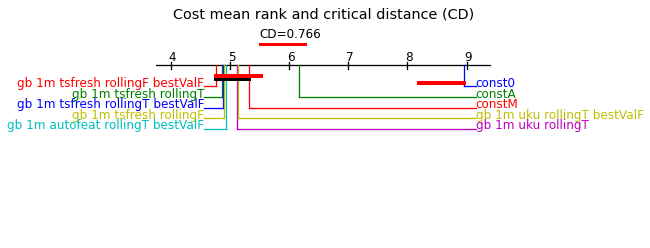

,cost: oracle,cost: gb 1m autofeat rollingT bestValF,cost: gb 1m tsfresh rollingF bestValF,cost: gb 1m tsfresh rollingT,cost: gb 1m tsfresh rollingT bestValF,cost: gb 1m tsfresh rollingF,cost: constM,cost: gb 1m uku rollingT bestValF,cost: gb 1m uku rollingT,cost: constA,cost: const0
mean,1.007541,1.133315,1.135918,1.136428,1.136760,1.137046,1.143734,1.147108,1.147336,1.162501,1.263104
median,0.194194,0.351898,0.342925,0.348230,0.348673,0.348230,0.299437,0.363509,0.363509,0.331840,0.422242


In [74]:
metric = 'cost'
plotCD(results[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=5)
meanMedian[[metric+': '+i for i in algos]].sort_values(by='mean',axis=1)

In [75]:
resultsDelta = results.copy(deep=True)
for i in [i for i in resultsDelta.columns if 'cost' in i]:
    alg = i.split('cost: ')[1]
    resultsDelta['excess cost: '+alg] = resultsDelta[i] - resultsDelta['cost: oracle']

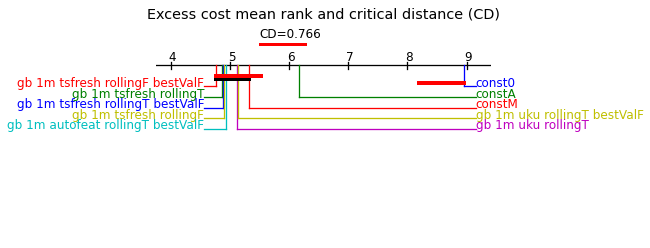

In [76]:
metric = 'excess cost'
plotCD(resultsDelta[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,filename='_EE')
#meanMedian[[metric+'_'+i for i in algos]]

In [30]:
resultsDelta[[metric+': '+i for i in algos[:-1]]].mean(axis=0).sort_values()

excess cost: gb 1m autosel rollingT bestValF    0.125774
excess cost: gb 1m tsfresh rollingF bestValF    0.128377
excess cost: gb 1m tsfresh rollingT             0.128887
excess cost: gb 1m tsfresh rollingT bestValF    0.129219
excess cost: gb 1m tsfresh rollingF             0.129506
excess cost: constM                             0.136193
excess cost: gb 1m uku rollingT bestValF        0.139567
excess cost: gb 1m uku rollingT                 0.139796
excess cost: constA                             0.154960
excess cost: const0                             0.255564
dtype: float64

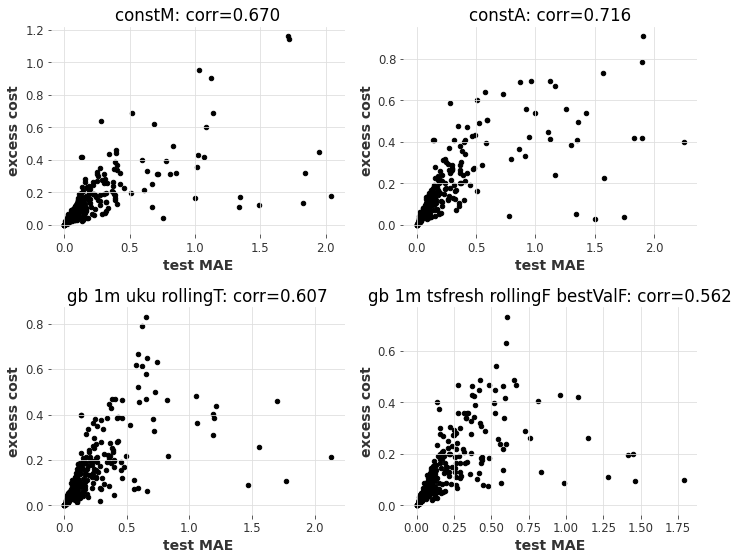

In [60]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10,8)) 

for i,c in enumerate(['constM','constA','gb 1m uku rollingT','gb 1m tsfresh rollingF bestValF']):
    ax=axs[i//2,i%2]
    X = 'mae: '+c
    Y= 'excess cost: '+c
    dd = resultsDelta[[X,Y]].copy(deep=True).rename(columns={X:'test '+X.split(':')[0].upper(),Y:Y.split(':')[0]})
    dd.plot(kind='scatter',x='test '+X.split(':')[0].upper(), y =Y.split(':')[0],ax=ax)
    ax.set_title(f"{c}: corr={resultsDelta[[X,Y]].corr().values[0,1]:.3f}")
    #ax.grid(None)
    ax.xaxis.set_tick_params(bottom=True,direction='out')
    ax.get_xaxis().set_visible(True)
plt.tight_layout()
plt.savefig('corr_EE.eps', format='eps',dpi=200,bbox_inches='tight')

In [77]:
eics = resultsDelta.reset_index()['eics'].unique()

eicBestRank = {}
for e in eics:
    d = resultsDelta.reset_index()
    d = d[d['eics']==e][[i for i in resultsDelta.columns if 'excess' in i]]
    d = d.rename(columns={i:i.split(': ')[1] for i in d.columns})
    dd = d[[i for i in d.columns if 'oracle' not in i]].rank(axis=1).mean(axis=0).sort_values()
    algo = dd.index[0]
    lastAlgo = dd.index[-1]
    eicBestRank[e] = str(algo) + ': ' + str(d[algo].mean()) + f'; {lastAlgo}:'+ str(d[lastAlgo].mean())

In [78]:
eicBestRank

{'B7B6B96D8CA1E97B16B47F51F58B6A6B': 'gb 1m autofeat rollingT bestValF: 0.2581058957799999; const0:0.49390523619999993',
 'B7B6B96D8CA1E97B9D9DE3B0AC99E9CB': 'gb 1m tsfresh rollingT bestValF: 0.11790906044666666; const0:0.2864388711333333',
 'B7B6B96D8CA1E97B224851B9682C286C': 'constA: 0.10713465170000012; const0:0.3647647548000001',
 'B7B6B96D8CA1E97B9B44F2A15EFF2DF7': 'gb 1m autofeat rollingT bestValF: 0.23074065103999974; constA:0.4647514077666665',
 'B7B6B96D8CA1E97BE180B979E8C7F24E': 'gb 1m tsfresh rollingT bestValF: 0.02359713113999998; const0:0.06432826393333337',
 'B7B6B96D8CA1E97B001C70C0C9AE7D59': 'gb 1m tsfresh rollingT: 0.13215750333793103; const0:0.2952494373793103',
 'B7B6B96D8CA1E97B29890582FC608BA9': 'gb 1m tsfresh rollingF bestValF: 0.08216674166; const0:0.16299254366666677',
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'constM: 0.10625357453846156; const0:0.24492579800000017',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'constM: 0.04215472249999996; constA:0.07640956496666661',
 'B7

In [79]:
eicBestRank2 = {}
diffs = []
for e in eics:
    d = resultsDelta.reset_index()
    d = d[d['eics']==e][[i for i in resultsDelta.columns if 'excess' in i]]
    d = d.rename(columns={i:i.split(': ')[1] for i in d.columns})
    dd = d[[i for i in d.columns if 'oracle' not in i]].rank(axis=1).mean(axis=0).sort_values()
    algo = 'gb 1m tsfresh rollingF bestValF'
    lastAlgo = dd.index[-1]
    eicBestRank2[e] = str(algo) + ': ' + str(d[algo].mean()) + f'; {lastAlgo}:'+ str(d[lastAlgo].mean())
    diffs +=[d[lastAlgo].mean()/d[algo].mean()]

eicBestRank2

{'B7B6B96D8CA1E97B16B47F51F58B6A6B': 'gb 1m tsfresh rollingF bestValF: 0.27727029948666665; const0:0.49390523619999993',
 'B7B6B96D8CA1E97B9D9DE3B0AC99E9CB': 'gb 1m tsfresh rollingF bestValF: 0.11667778045333337; const0:0.2864388711333333',
 'B7B6B96D8CA1E97B224851B9682C286C': 'gb 1m tsfresh rollingF bestValF: 0.1476096136533334; const0:0.3647647548000001',
 'B7B6B96D8CA1E97B9B44F2A15EFF2DF7': 'gb 1m tsfresh rollingF bestValF: 0.24430191226666664; constA:0.4647514077666665',
 'B7B6B96D8CA1E97BE180B979E8C7F24E': 'gb 1m tsfresh rollingF bestValF: 0.023752542273333312; const0:0.06432826393333337',
 'B7B6B96D8CA1E97B001C70C0C9AE7D59': 'gb 1m tsfresh rollingF bestValF: 0.13185012955862066; const0:0.2952494373793103',
 'B7B6B96D8CA1E97B29890582FC608BA9': 'gb 1m tsfresh rollingF bestValF: 0.08216674166; const0:0.16299254366666677',
 'B7B6B96D8CA1E97B0A7628046D7E2ED3': 'gb 1m tsfresh rollingF bestValF: 0.13676428084615383; const0:0.24492579800000017',
 'B7B6B96D8CA1E97B4D51F3D61DFEA629': 'gb 1

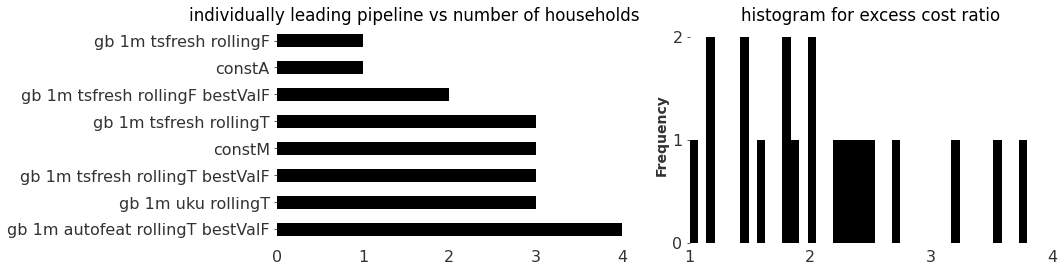

In [81]:
d0 =pd.read_csv('data/consumption_2021.csv')


plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,4)) 
ax=axs[0]
ee=[eicBestRank[i].split(':')[0] for i in eicBestRank]
pd.DataFrame({'pipeline':ee})['pipeline'].value_counts().plot(kind='barh',width=0.5,fontsize=16,ax=ax)
ax.set_xticks([0,1,2,3,4])
ax.grid(False)
ax.set_title('individually leading pipeline vs number of households',loc='right')

ax=axs[1]
pd.DataFrame({'diffs':diffs}).plot.hist(bins=40,xlim=(1,4),ax=ax,legend='',fontsize=16)
ax.set_yticks([0,1,2])
ax.set_xticks([1,2,3,4])
ax.grid(False)
ax.set_title('histogram for excess cost ratio')

plt.tight_layout();
#plt.savefig('excessCost_chart.eps', format='eps',dpi=200,bbox_inches='tight')

<AxesSubplot:ylabel='Frequency'>

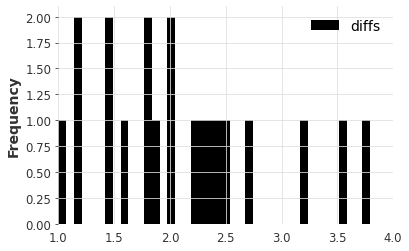

In [ ]:
resultsDelta[[metric+': '+i for i in algos]].mean(axis=0).sort_values()#.to_frame().T.assign(name='mean').set_index('name').rename_axis(None)


#re[[metric+': '+i for i in algos]][[': naive']]

In [ ]:
eics = results.reset_index()['eic'].unique()

eicBestRank = {}
for e in eics:
    d = results.reset_index()
    d = d[d['eic']==e][[i for i in results.columns if 'MAE' in i]]
    d = d.rename(columns={i:i.split(': ')[1] for i in d.columns})
    eicBestRank[e] = d[[i for i in d.columns if 'oracle' not in i]].rank(axis=1).mean(axis=0).sort_values().index[0]

In [ ]:
eicBestRank

In [ ]:
d0 =pd.read_csv('data/consumption_2021.csv')


plt.rcParams.update({'font.size': 14})

fig, (axs1,axs2,axs3) = plt.subplots(nrows=3, ncols=1,figsize=(15,8),gridspec_kw={'height_ratios': [2, 1,1]}) 
axs=(axs1,axs2,axs3)
ax=axs[0]

pd.DataFrame({'pipeline':list(eicBestRank.values())})['pipeline'].value_counts().plot(kind='barh',ax=ax,width=0.5,fontsize=16)
ax.set_xticks([0,1,2,3])
ax.set_xlim(0,10)
#ax.set_ylim(0,11)
ax.grid(False)

ax=axs[1]
e1 = 'B7B6B96D8CA1E97B001C70C0C9AE7D59'
d1 = d0[d0['EIC']==e1]
d1['TIME']=pd.DatetimeIndex(d1['TIME'])
d1 = d1.set_index('TIME').rename_axis(None)[['AMOUNT']].rename(columns={'AMOUNT':'load'})
load1 = d1.values.reshape((d1.shape[0]//24,24)).T
im1 = ax.imshow(load1,cmap='binary')
ax.set_yticks([0,23])
ax.set_xticks([0,364])
plt.colorbar(im1,ax=ax,fraction=0.015, pad=0.04,aspect=5)
ax.set_title('for such a household the leading pipeline is gb 1m tsfresh rollingF bestValF')

ax=axs[2]
e2 = 'B7B6B96D8CA1E97BB86AAB5DEBE89493'

d2 = d0[d0['EIC']==e2]
d2['TIME']=pd.DatetimeIndex(d2['TIME'])
d2 = d2.set_index('TIME').rename_axis(None)[['AMOUNT']].rename(columns={'AMOUNT':'load'})
load2 = d2.values.reshape((d2.shape[0]//24,24)).T
im2 = ax.imshow(load2,cmap='binary')
ax.set_yticks([0,23])
ax.set_xticks([0,364])
plt.colorbar(im2,ax=ax,fraction=0.015, pad=0.04,aspect=5)
ax.set_title('for such a household the leading pipeline is const0')

plt.tight_layout();
#plt.savefig('testMae_chart.eps', format='eps',dpi=200,bbox_inches='tight')

In [ ]:
metric = 'testWmape'
plotCD(results[[metric+': '+i for i in algos[:-1]]],algos[:-1],metric,left=14,filename='_EE')
meanMedian[[metric+': '+i for i in algos]].sort_values(by='mean',axis=1)

Overall leader is GbTsfreshFF
- Regarding TestMAE, simplification is possible towards GbUku and constM (statistically the same as leader)
- Regarding TestR2, simplification is possible towards GbSel (statistically the same as leader)
- Regarding TestWmape, simplification is possible towards GbUku (statistically the same as leader)